# Estimate persistence times

How long do viruses circulate in domestic prior to infecting humans? How long do viruses persist in domestic after transmission from wild? This notebook will attempt to answer those questions.

In [19]:
import glob
import re,copy, imp
import pandas as pd 
import numpy as np

# for this to work, you will need to download the most recent version of baltic, available here 
bt = imp.load_source('baltic', '/Users/lmoncla/src/baltic/baltic/baltic.py')

%matplotlib inline
import matplotlib as mpl
from matplotlib import pyplot as plt
import matplotlib.patheffects as path_effects
import matplotlib.lines as mlines
from matplotlib.font_manager import FontProperties
import matplotlib.colors as clr
import textwrap as textwrap
from textwrap import wrap

import time
from io import StringIO

import rpy2
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [20]:
from datetime import date
current_date = str(date.today())

In [21]:
# define colors 
domestic_color="#4E83AE"
wild_color="#CEB540"
human_color="#DE4428"

In [22]:
def get_taxa_lines(tree_path):    
    # write out a temp tree file
#     temp_tree = tree_path.replace(".trees",".temp.tree")
#     with open(temp_tree, "w") as outfile: 
#         outfile.write("")

    lines_to_write = ""
    with open(tree_path, 'rU') as infile:
        for line in infile: ## iterate through each line
            if 'state' not in line.lower(): #going to grab all the interesting stuff in the .trees file prior to the newick tree strings
                lines_to_write = lines_to_write + line

    return(lines_to_write)

In [23]:
def get_burnin_value(tree_path, burnin_percent):
    with open(tree_path, 'rU') as infile:
        numtrees = 0
        for line in infile: ## iterate through each line
            if 'state' in line.lower(): #going to grab all the interesting stuff in the .trees file prior to the newick tree strings
                numtrees += 1
    
    burnin = numtrees * burnin_percent
    return(burnin)

In [24]:
def find_host_tips(tree, host):
    
    df_to_return = pd.DataFrame()
    
    for k in tree.Objects: 
        if k.branchType == "leaf":
            if k.traits['typeTrait'] == host:
                branch_length_avian = 0
                region = k.name.split("|")[4]
                
                parent, parent_type, branch_length_avian = compute_domestic_branch_length(k, branch_length_avian)
                
                local_df = pd.DataFrame.from_dict({"tip":[k.name], 
                                                   "time_in_domestic":branch_length_avian,
                                                  "region":region})
                df_to_return = df_to_return.append(local_df)
                
                
    return(df_to_return)

In [25]:
def compute_domestic_branch_length(tip, cumulative_branch_length):
    
    parent = tip.parent
    parent_branch_length = parent.length
    
    if 'typeTrait' in parent.traits:
        parent_type = parent.traits['typeTrait']
    else:
        parent_type = "unknown"
    
    if parent_type == 'domestic':
        cumulative_branch_length += parent_branch_length
        node, node_type, cumulative_branch_length = compute_domestic_branch_length(parent, cumulative_branch_length)
        
    # if parent branch type is human, don't add the branch length, but do go up a node and try again until you reach a domestic one
    elif parent_type == 'human':
        node, node_type, cumulative_branch_length = compute_domestic_branch_length(parent, cumulative_branch_length)
    
    # else, parent branch must be wild or root. Either way, return current branch length
    else:
        node, node_type = parent, parent_type
    
    return(node, node_type, cumulative_branch_length)

In [26]:
def run_on_trees(trees_file, host):
    
    start_time = time.time()

    with open(trees_file, "r") as infile:

        df = pd.DataFrame()
        tree_counter = 0
        trees_processed = 0
        migrations_dict = {}

        for line in infile:
            if 'tree STATE_' in line:
                tree_counter += 1

                if tree_counter > burnin:
                    trees_processed += 1
                    temp_tree = StringIO(taxa_lines + line)
                    tree = bt.loadNexus(temp_tree)

                    # run stuff
                    local_df = find_host_tips(tree, host)
                    local_df['tree_number'] = tree_counter
                    df = df.append(local_df)

    # print the amount of time this took
    total_time_seconds = time.time() - start_time
    total_time_minutes = total_time_seconds/60
    print("this took", total_time_seconds, "seconds (", total_time_minutes," minutes) to run on", trees_processed, "trees")
    return(df)

## Read in trees file and remove burnin

In [27]:
# trees file paths
constant_human_on = {"label": "constant-human-on","mig_direction":"backwards in time",
    "trees":"beast-runs/2021-03-15-mascot-3deme-constant/with-human-mig/3deme-mascot-constant-with-human-mig-2021-03-15.combined.trees"}
constant_human_off = {"label": "constant-human-off","mig_direction":"backwards in time",
    "trees":"beast-runs/2021-03-15-mascot-3deme-constant/no-human-mig/3deme-mascot-constant-no-human-mig-2021-03-15.combined.trees"}
skyline_human_on =  {"label": "skyline-human-on", "mig_direction":"forwards in time",
                     "trees": "beast-runs/2021-03-15-mascot-3deme-skyline-with-mig-history/with-human-mig/2021-04-27-mascot-3deme-skyline-with-human-mig.combined.trees"}
skyline_human_off = {"label": "skyline-human-off", "mig_direction":"forwards in time",
                     "trees": "beast-runs/2022-04-19-mascot-3deme-skyline-fixed-muts-logger/combined-2022-06-01.muts.trees"}

In [28]:
to_run = skyline_human_off

trees_file_path = to_run['trees']
label = to_run['label']

burnin_percent = 0

In [29]:
all_trees = trees_file_path
burnin_percent = 0

taxa_lines = get_taxa_lines(all_trees)
burnin = get_burnin_value(all_trees, burnin_percent)
print(burnin)

/Users/lmoncla/anaconda/envs/LHM-basics/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: 'U' mode is deprecated
  


0


/Users/lmoncla/anaconda/envs/LHM-basics/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: 'U' mode is deprecated
  


## Return time in domestic for human or domestic tips

To run for human tips, set host tip state to human; for domestic, set to domestic

In [55]:
# now, run 
trees_file = all_trees
host_tip_state = "human"

df = run_on_trees(all_trees, host_tip_state)

this took 375.0464301109314 seconds ( 6.25077383518219  minutes) to run on 1133 trees


In [56]:
df.head()

,tip,time_in_domestic,region,tree_number
0,A/Alberta/1/2014|2014.005|2014-01-03|Human|Nor...,0.182984,North_America,1
0,A/Nanjing/1/2015|2015.055|2015-01-21|Human|Chi...,0.346522,China,1
0,A/Hubei/1/2010|2010.384|2010-05-21|Human|China...,7.777728,China,1
0,A/Vietnam/CM32/2011|2011.797|2011-10-19|Human|...,7.969168,Southeast_Asia,1
0,A/Nepal/19FL1997/2019|2019.227|2019-03-25|Huma...,0.063984,South_Asia,1


In [57]:
# write out to tsv
csv_path = to_run['trees'].replace(".trees",".trees."+host_tip_state+".persistence-times-"+current_date+".tsv")
df.to_csv(csv_path, sep="\t")

In [58]:
# read dataframe back in
read_in_path = to_run['trees'].replace(".trees",".trees."+host_tip_state+".persistence-times-2022-06-07.tsv")
df = pd.read_csv(read_in_path, sep="\t")

In [59]:
# here, I am removing any values that are 0.0. These derive from human infections from which we have no sampled
# domestic ancestors. So they are inferred as directly infected from wild birds. 
print(len(df))
df_dom_only = df[df['time_in_domestic'] > 0]
print(len(df_dom_only))

141625
140022


In [60]:
df_dom_only['time_in_domestic'].mean()

4.29745448006148

In [61]:
df_dom_only['time_in_domestic'].std()

3.265161464264802

In [62]:
df_dom_only['time_in_domestic'].median()

3.549635948239003

In [63]:
import pymc3
pymc3.stats.hpd(df_dom_only['time_in_domestic'], 0.95)

array([1.58439738e-04, 1.02462633e+01])

In [64]:
def convert_df_to_proportions_df(input_df):
    
    # convert to proportions for plotting
    proportions_df = pd.DataFrame()
    total_events = len(input_df)

    for i in range(0,25,1):
        lower_bound = i
        upper_bound = i+1
        local_df = input_df[(input_df['time_in_domestic'] > lower_bound) & (input_df['time_in_domestic'] <= upper_bound)]
        total_in_bin = len(local_df)
        cumulative_time = local_df['time_in_domestic'].sum()
        new_df = pd.DataFrame.from_dict({"n_years":[lower_bound], "total_across_posterior":total_in_bin, 
                                                "proportion_of_events":float(total_in_bin/total_events), 
                                        "cumulative_time":[cumulative_time], "rate_per_year":float(total_in_bin/cumulative_time)})
        proportions_df = proportions_df.append(new_df)

    return(proportions_df)

In [65]:
proportions_df = convert_df_to_proportions_df(df_dom_only)
proportions_df.head()

,n_years,total_across_posterior,proportion_of_events,cumulative_time,rate_per_year
0,0,23840,0.170259,11137.887431,2.140442
0,1,17704,0.126437,27063.056238,0.654176
0,2,20122,0.143706,50026.267812,0.402229
0,3,16522,0.117996,58146.422360,0.284145
0,4,12251,0.087493,54377.423835,0.225296


In [66]:
# the only way this really makes sense is if the only lineages that we allow to circulate long-term are the ones 
# that we don't know about, because they never cause human infections; human infections tend to descend from new
# importations from wild birds, rather than from endemic, long-term circulation -> WHY? Is this fully explained 
# by which lineages are high path vs. low-path? that would be very boring. 

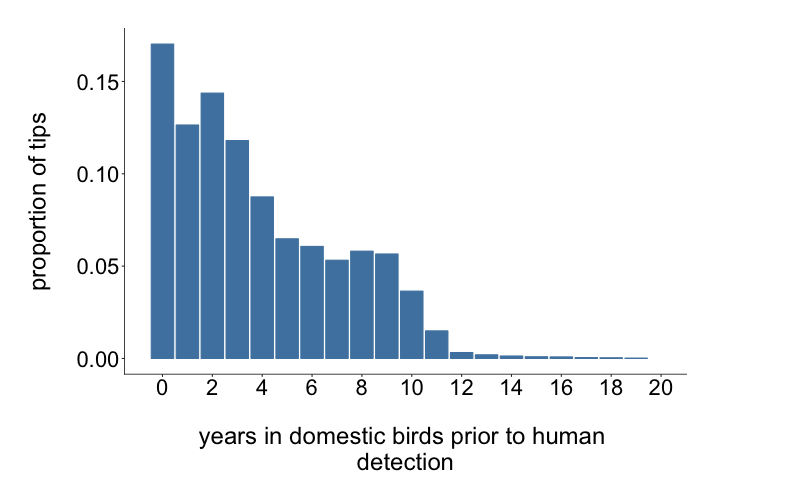

In [67]:
%%R -w 800 -h 500 -u px -i proportions_df,label,host_tip_state,current_date,human_color,wild_color,domestic_color # this sets the size of the plot...otherwise, it will go off the page

require(ggplot2)
library(ggplot2)
library(RColorBrewer)

output_filename = paste("persistence-times-",host_tip_state,"-",current_date,".pdf", sep="")

p <- ggplot(data=proportions_df, aes(x=n_years, y=proportion_of_events)) + 
    geom_col(color=domestic_color, fill=domestic_color)+
    #facet_wrap(~region)+
    #geom_point(size=1, alpha=0.6)+
    #geom_boxplot()+
    #geom_line(stat="count")+
    labs(x=paste("\nyears in domestic birds prior to",host_tip_state,"\ndetection"), y="proportion of tips\n")+
    #scale_y_continuous(breaks=seq(0,0.18,0.03), limits=c(0,0.18))+
    scale_x_continuous(breaks=seq(0,20,2), limits=c(-0.5,20))+
    theme(panel.grid.major=element_line(colour=NA,size=NA))+    
    theme(panel.grid.minor=element_line(colour=NA,size=NA))+    
    theme(strip.background = element_rect(colour=NA, fill=NA))+
    theme(axis.line.x=element_line(colour="black"))+
    theme(axis.line.y=element_line(colour="black"))+
    theme(axis.title=element_text(size=24, vjust=5))+
    theme(axis.text.y=element_text(size=22, colour="black"))+
    theme(axis.text.x=element_text(size=22, colour="black", hjust=0.5))+
    theme(legend.text=element_text(size=20))+
    theme(legend.title=element_blank())+
    theme(panel.margin=unit(1, "lines"))+
    theme(plot.margin=unit(c(1,4,1,1),"cm"))+
    theme(legend.key.size=unit(0.7, "cm"))+
    theme(panel.background=element_rect(fill=NA))+
    theme(legend.key=element_rect(fill=NA))
    ##theme(legend.position = c(legend_x, legend_y))

ggsave(output_filename, width = 10, height = 6, device = "pdf", path = "figures", dpi = 300)
p

In [76]:
df.head()

,Unnamed: 0,tip,time_in_domestic,region,tree_number
0,0,A/Alberta/1/2014|2014.005|2014-01-03|Human|Nor...,0.182984,North_America,1
1,0,A/Nanjing/1/2015|2015.055|2015-01-21|Human|Chi...,0.346522,China,1
2,0,A/Hubei/1/2010|2010.384|2010-05-21|Human|China...,7.777728,China,1
3,0,A/Vietnam/CM32/2011|2011.797|2011-10-19|Human|...,7.969168,Southeast_Asia,1
4,0,A/Nepal/19FL1997/2019|2019.227|2019-03-25|Huma...,0.063984,South_Asia,1


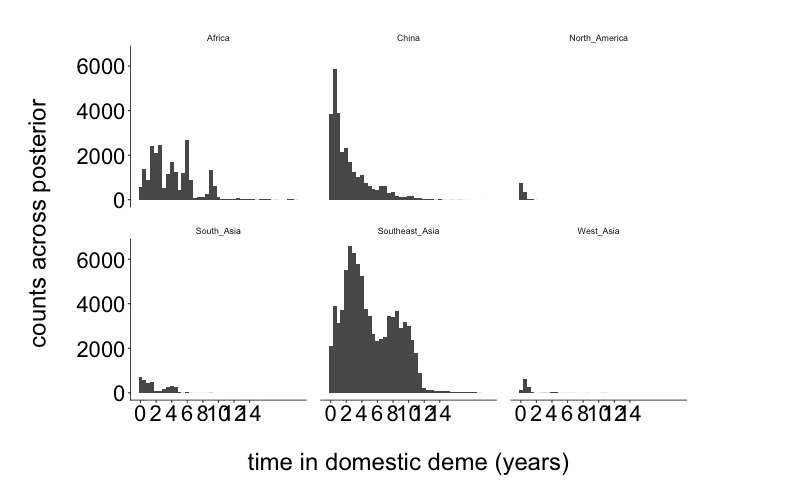

In [68]:
%%R -w 800 -h 500 -u px -i df,label,host_tip_state,current_date,human_color,wild_color,domestic_color # this sets the size of the plot...otherwise, it will go off the page

require(ggplot2)
library(ggplot2)
library(RColorBrewer)

output_filename = paste("persistence-times-by-region-",host_tip_state,"-",current_date,".pdf", sep="")

p <- ggplot(data=df, aes(x=time_in_domestic)) + 
    geom_histogram(binwidth=0.5)+
    facet_wrap(~region)+
    #geom_point(size=1, alpha=0.6)+
    #geom_boxplot()+
    #geom_line(stat="count")+
    labs(x="\ntime in domestic deme (years)", y="counts across posterior\n")+
    #scale_y_continuous(breaks=seq(0,0.2,0.05), limits=c(0,0.2))+
    scale_x_continuous(breaks=seq(0,15,2))+
    theme(panel.grid.major=element_line(colour=NA,size=NA))+    
    theme(panel.grid.minor=element_line(colour=NA,size=NA))+    
    theme(strip.background = element_rect(colour=NA, fill=NA))+
    theme(axis.line.x=element_line(colour="black"))+
    theme(axis.line.y=element_line(colour="black"))+
    theme(axis.title=element_text(size=24, vjust=5))+
    theme(axis.text.y=element_text(size=22, colour="black"))+
    theme(axis.text.x=element_text(size=22, colour="black", hjust=0.5))+
    theme(legend.text=element_text(size=20))+
    theme(legend.title=element_blank())+
    theme(panel.margin=unit(1, "lines"))+
    theme(plot.margin=unit(c(1,4,1,1),"cm"))+
    theme(legend.key.size=unit(0.7, "cm"))+
    theme(panel.background=element_rect(fill=NA))+
    theme(legend.key=element_rect(fill=NA))
    ##theme(legend.position = c(legend_x, legend_y))

ggsave(output_filename, width = 12, height = 6, device = "pdf", path = "figures", dpi = 300)
p

In [69]:
# now, let's plot time in domestic for human and domestic infecting lineages on the same bar plot 


In [70]:
# read dataframe back in
domestic_path = to_run['trees'].replace(".trees",".trees.domestic.persistence-times-2022-06-07.tsv")
dom_df = pd.read_csv(domestic_path, sep="\t")

human_path = to_run['trees'].replace(".trees",".trees.human.persistence-times-2022-06-07.tsv")
human_df = pd.read_csv(human_path, sep="\t")

In [71]:
human_df_dom_only = human_df[human_df['time_in_domestic'] > 0]
human_proportions_df = convert_df_to_proportions_df(human_df_dom_only)
human_proportions_df.head()

,n_years,total_across_posterior,proportion_of_events,cumulative_time,rate_per_year
0,0,23840,0.170259,11137.887431,2.140442
0,1,17704,0.126437,27063.056238,0.654176
0,2,20122,0.143706,50026.267812,0.402229
0,3,16522,0.117996,58146.422360,0.284145
0,4,12251,0.087493,54377.423835,0.225296


In [72]:
dom_df_dom_only = dom_df[dom_df['time_in_domestic'] > 0]
dom_proportions_df = convert_df_to_proportions_df(dom_df_dom_only)
dom_proportions_df.head()

,n_years,total_across_posterior,proportion_of_events,cumulative_time,rate_per_year
0,0,95797,0.354405,41621.664576,2.301614
0,1,47434,0.175484,69459.116836,0.682905
0,2,30789,0.113905,74994.236199,0.410552
0,3,19334,0.071527,67998.424811,0.284330
0,4,19567,0.072389,88596.807264,0.220854


In [73]:
import pymc3
print("human", pymc3.stats.hpd(human_df_dom_only['time_in_domestic'], 0.5))
print(human_df_dom_only['time_in_domestic'].mean())
print(human_df_dom_only['time_in_domestic'].median())
print(human_df_dom_only['time_in_domestic'].std())

print("domestic", pymc3.stats.hpd(dom_df_dom_only['time_in_domestic'], 0.5))
print(dom_df_dom_only['time_in_domestic'].mean())
print(dom_df_dom_only['time_in_domestic'].median())
print(dom_df_dom_only['time_in_domestic'].std())

human [1.58439738e-04 3.54965073e+00]
4.29745448006148
3.549635948239003
3.265161464264802
domestic [2.80838365e-05 1.80467501e+00]
2.91058687293739
1.8046677828432194
2.9464756345399805


In [74]:
human_proportions_df['host_tip'] = "human"
dom_proportions_df['host_tip'] = 'domestic'
combined_proportions_df = human_proportions_df.append(dom_proportions_df)
print(len(combined_proportions_df))
combined_proportions_df.head()

50


,n_years,total_across_posterior,proportion_of_events,cumulative_time,rate_per_year,host_tip
0,0,23840,0.170259,11137.887431,2.140442,human
0,1,17704,0.126437,27063.056238,0.654176,human
0,2,20122,0.143706,50026.267812,0.402229,human
0,3,16522,0.117996,58146.422360,0.284145,human
0,4,12251,0.087493,54377.423835,0.225296,human


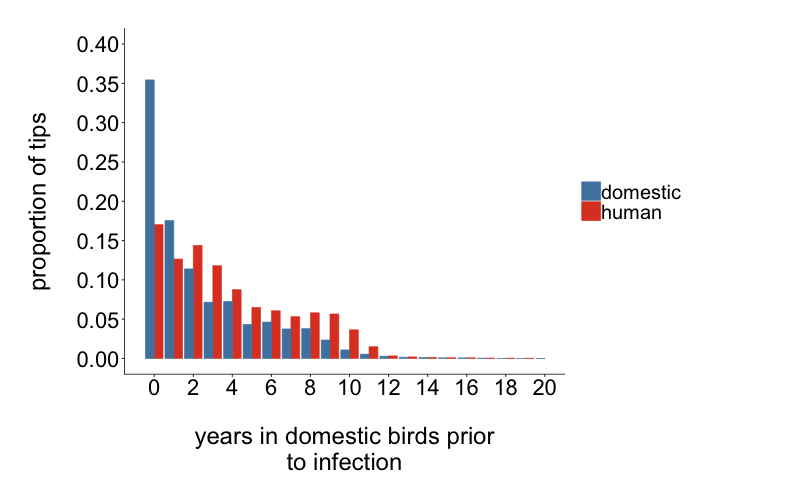

In [75]:
%%R -w 800 -h 500 -u px -i combined_proportions_df,label,host_tip_state,current_date,human_color,wild_color,domestic_color # this sets the size of the plot...otherwise, it will go off the page

require(ggplot2)
library(ggplot2)
library(RColorBrewer)

output_filename = paste("persistence-times-",current_date,".pdf", sep="")

p <- ggplot(data=combined_proportions_df, aes(x=n_years, y=proportion_of_events, color=host_tip, fill=host_tip)) + 
    geom_col(position="dodge", size=0.3)+
    #facet_wrap(~region)+
    #geom_point(size=1, alpha=0.6)+
    #geom_boxplot()+
    #geom_line(stat="count")+
    scale_color_manual(values=c("human"=human_color, "domestic"=domestic_color))+
    scale_fill_manual(values=c("human"=human_color, "domestic"=domestic_color))+
    labs(x=paste("\nyears in domestic birds prior\nto infection"), y="proportion of tips\n")+
    scale_y_continuous(breaks=seq(0,0.4,0.05), limits=c(0,0.4))+
    scale_x_continuous(breaks=seq(0,20,2), limits=c(-0.5,20))+
    theme(panel.grid.major=element_line(colour=NA,size=NA))+    
    theme(panel.grid.minor=element_line(colour=NA,size=NA))+    
    theme(strip.background = element_rect(colour=NA, fill=NA))+
    theme(axis.line.x=element_line(colour="black"))+
    theme(axis.line.y=element_line(colour="black"))+
    theme(axis.title=element_text(size=24, vjust=5))+
    theme(axis.text.y=element_text(size=22, colour="black"))+
    theme(axis.text.x=element_text(size=22, colour="black", hjust=0.5))+
    theme(legend.text=element_text(size=20))+
    theme(legend.title=element_blank())+
    theme(panel.margin=unit(1, "lines"))+
    theme(plot.margin=unit(c(1,4,1,1),"cm"))+
    theme(legend.key.size=unit(0.7, "cm"))+
    theme(panel.background=element_rect(fill=NA))+
    theme(legend.key=element_rect(fill=NA))
    ##theme(legend.position = c(legend_x, legend_y))

ggsave(output_filename, width = 10, height = 6, device = "pdf", path = "figures", dpi = 300)
p

### Summary

I guess this result could be summarized by saying that if you randomly choose a human infection, that virus will have circulated on average for about twice as long in poultry as a randomly chosen domestic bird infection. This could just be because human infections are rare, so it takes twice as long to find a host if you are a bird virus; or it could be that human infections are enriched among long-circulating lineages.  